In [11]:
%reload_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm

import numpy as np
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck18 as cosmo

import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap

import halomod

sys.path.append("../..")
from dm21cm.utils import save_h5_dict

import matplotlib.pyplot as plt

# Basic NFW-ology

Let overdensity $\Delta=200$, then enclosed mass within $r_\Delta$ is 
$$M=\frac{4\pi}{3}r_\Delta^3\Delta\rho_c.$$

Since $r_\Delta=c\cdot r_s$,
$$M=\frac{4\pi}{3}c^3r_s^3\Delta\rho_c,$$
and
$$r_s=\left(\frac{3M}{4\pi\Delta \rho_c c^3}\right)^{1/3}$$

In [ ]:
G = c.G.to(u.pc**3/ u.M_sun / u.s**2).value # [pc^3 / Msun / s^2]
c_light = c.c.to(u.pc/u.s).value # [pc / s]

z_arr = jnp.linspace(0, 55, 1000)
rho_crit_arr = cosmo.critical_density(z_arr).to('M_sun / pc^3').value # [Msun / pc^3]

def get_critical_density(z):
    return jnp.interp(z, z_arr, rho_crit_arr) # [Msun / pc^3]

def get_halo_information(M, c, z): # ([Msun], [1], [1])
    rho_c = get_critical_density(z) # [Msun / pc^3]
    delta = 200
    r_s = ((3 * M)/(4 * jnp.pi * c**3 * delta * rho_c))**(1/3) # [pc]
    r_delta = c * r_s # [pc]
    rho_s = ((1 + c)*M)/(16 * jnp.pi * r_s**3 * (-c + jnp.log(1 + c) + c*jnp.log(1 + c))) # [Msun / pc^3]
    return rho_s, r_s, r_delta # [Msun / pc^3], [pc], [pc]

def nfw_density(r, rho_s, r_s): # ([pc], [Msun / pc^3], [pc])
    return 4 * rho_s / ((r/r_s) * (1 + r/r_s)**2) # [Msun / pc^3]

def nfw_enclosed(r, rho_s, r_s): # ([pc], [Msun / pc^3], [pc])
    return 16 * jnp.pi * r_s**3 * rho_s * (-(r / (r + r_s)) - jnp.log(r_s) + jnp.log(r + r_s)) # [Msun]

def nfw_phi(r, rho_s, r_s): # ([pc], [Msun / pc^3], [pc])
    return - 16 * jnp.pi * G * rho_s * r_s**3 / r * jnp.log(1 + r / r_s) # [pc^2 / s^2]

# Jeans Analysis with the MB Approximation

Following the details from: https://arxiv.org/pdf/2005.03955.pdf#page=55&zoom=100,122,684

In [5]:
def jeans_integrand(r, rho_s, r_s): # ([pc], [Msun / pc^3], [pc])
    return nfw_density(r, rho_s, r_s) * nfw_enclosed(r, rho_s, r_s) / r**2 # [Msun^2 / pc^5]

def get_sigma_v(r, rho_s, r_s, r_delta): # ([pc], [Msun / pc^3], [pc], [pc])
    logr_arr = jnp.linspace(jnp.log(r), jnp.log(r_delta), 300)
    r_arr = jnp.exp(logr_arr)
    integral = jnp.trapz(r_arr * jeans_integrand(r_arr, rho_s, r_s), logr_arr) # [Msun^2 / pc^4]
    v_disp = 3 * G / nfw_density(r, rho_s, r_s) * integral # [pc^2 / s^2]
    return jnp.sqrt(v_disp) # [pc / s]

def get_ve(r, rho_s, r_s, r_delta): # ([pc], [Msun / pc^3], [pc], [pc])
    psi = nfw_phi(r_delta, rho_s, r_s)- nfw_phi(r, rho_s, r_s) # [pc^2 / s^2]
    return jnp.sqrt(2*psi) # [pc / s]

### Relative Velocity Distribution from the Maxwell-Boltzmann Approximation

Using the Maxwell-Boltzmann approximation, we have the positionally dependent velocity distribution as
\begin{equation}
f(\vec{v} | r) \propto \frac{1}{N} \left[\exp \left( -\frac{v^2}{v_0^2}\right) - \exp \left( -\frac{v_e^2}{v_0^2}\right)\right]
\end{equation}
up to some overall normalization factor $N$, which depends on the radius of evaluation.

To evaluate the relative velocity dispersion, we compute
\begin{equation}
\langle v_\mathrm{rel}^2\rangle = \langle (\vec{v} - \vec{w})^2\rangle  = \int d^3 \vec{v} d^3\vec{w} f(\vec{v}, r) f(\vec{w}, r) |\vec{v} - \vec{w}|^2.
\end{equation}
This can be evaluated analytically, with the result given in the method below.

In [6]:
def rel_v_disp(r, rho_s, rs, rMax): # ([pc], [Msun / pc^3], [pc], [pc])
    ve = get_ve(r, rho_s, rs, rMax) # [pc / s]
    sigma_v = get_sigma_v(r, rho_s, rs, rMax) # [pc / s]
    v0 = jnp.sqrt(2/3) * sigma_v # Jeans model for NFW
    ve = ve / v0 # [1]
    res = 3*v0**2 + (24*v0**5*ve**5)/(5.*(6*v0**3*ve + 4*v0**3*ve**3 - 3*jnp.exp(ve**2)*jnp.sqrt(jnp.pi)*v0**3*jsp.special.erf(ve))) # [pc^2 / s^2]
    return res / c_light**2 # [1]

# Evaluate Annihilation Rate over the Halo

The annihilation rate integrated over the halo is
\begin{equation}
\frac{dN}{dt} = \int dV \frac{dN}{dV dt} = \frac{1}{2}\int dV \langle \sigma v \rangle n_\mathrm{DM}^2
\end{equation}
where $n_\mathrm{dm}$ is the number density of dark matter. We can then write this as
\begin{equation}
\frac{dN}{dt} = \frac{1}{2} \left(\frac{1}{m_\mathrm{DM}} \frac{\Omega_\mathrm{DM}}{\Omega_\mathrm{DM}+\Omega_\mathrm{B}}  \right)^2 \int dV \langle \sigma v \rangle \rho^2.
\end{equation}

Next, we define the p-wave velocity-averaged cross-section as
\begin{equation}
\langle \sigma v \rangle = C_\sigma \times \frac{\langle v_\mathrm{rel}^2 \rangle}{c^2}
\end{equation}
where $C_\sigma$ is a constant and $\langle v_\mathrm{rel}^2 \rangle$ is the positionally-dependent average of the squared relative velocity.

Now we will compute
\begin{equation}
\frac{d\bar N}{dt} = \frac{1}{2 c^2} \left(\frac{\Omega_\mathrm{DM}}{\Omega_\mathrm{DM}+\Omega_\mathrm{B}}  \right)^2 \int dV v_\mathrm{rel}(r)^2 \rho^2
\end{equation}
so that we can compute the halo annihilation rate as
\begin{equation}
\frac{dN}{dt} = \frac{C_\sigma}{m_\mathrm{DM}^2} \frac{d\bar N}{dt}
\end{equation}

In [8]:
rel_v_disp_vmap = vmap(rel_v_disp, in_axes=(0, None, None, None))
omega_dm_frac = cosmo.Odm0 / (cosmo.Odm0+cosmo.Ob0)

def integrate_annihilation(rho_s, r_s, r_delta): # ([Msun / pc^3], [pc], [pc])
    r_arr = jnp.geomspace(1e-4*r_s, r_delta, 1001) # [pc]
    rel_v_disp_arr = jnp.nan_to_num(rel_v_disp_vmap(r_arr, rho_s, r_s, r_delta)) # [1]
    integrand = 4*np.pi * r_arr**2 * rel_v_disp_arr * nfw_density(r_arr, rho_s, r_s)**2 # [Msun^2 / pc^4]
    return 1/2 * omega_dm_frac**2 * jnp.trapz(integrand, r_arr) # [Msun^2 / pc^3]

@jit
def get_halo_annihilation(M, c, z): # ([Msun], [1], [1])
    rho_s, r_s, r_delta = get_halo_information(M, c, z) # [Msun / pc^3], [pc], [pc]
    return integrate_annihilation(rho_s, r_s, r_delta) # [Msun^2 / pc^3]

In [9]:
hm = halomod.DMHaloModel(
    halo_concentration_model='Ludlow16',
    z = 0, Mmin = 0., Mmax = 19, dlog10m = 0.025,
    mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
)
m_range = np.copy(hm.m)
z_range = np.linspace(0, 50, 51)

In [10]:
annihilation_rates = np.zeros((len(z_range), len(m_range)))

for i, z in enumerate(tqdm(z_range)):
    hm = halomod.DMHaloModel(
        halo_concentration_model='Ludlow16', z=z_range[i],
        Mmin = 0., Mmax = 19, dlog10m = .025,
        mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
    )
    for j in range(len(hm.m)):
        annihilation_rates[i, j] = get_halo_annihilation(hm.m[j], hm.cmz_relation[j], z)

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [01:20<00:00,  1.59s/it]


In [12]:
res_dict = {
    'z_range': z_range,
    'm_range': m_range,
    'ann_rates': annihilation_rates # [Msun^2 / pc^3]
}
save_h5_dict('../../data/pwave/ann_rates_zm.h5', res_dict)

Since
    $$\frac{dN}{dt}=\frac{C_\sigma}{m_{DM}^2}\frac{d\tilde N}{dt}$$
the dimensions are
    $$\frac{1}{T}=\frac{pL^3/T}{M^2}\frac{M^2}{pL^3},$$
where $p$ stands for physical. `annihilation_rates` tables contains $d\tilde N/dt$. The units would be
    $$\frac{M_\odot^2 c^4}{\mathrm{ppc}^3}\text{\quad or\quad}\frac{M_\odot\text{(energy)}^2}{\mathrm{ppc}^3}$$
After multiplying with the factor 4.23e58 it becomes
    $$\frac{\mathrm{GeV}^2}{\mathrm{pcm}^3}$$

In [13]:
np.min(annihilation_rates), np.max(annihilation_rates)

(1.6514133386913736e-15, 1.0487010935420825e+23)

Text(0.5, 0, 'Mass [M_sun]')

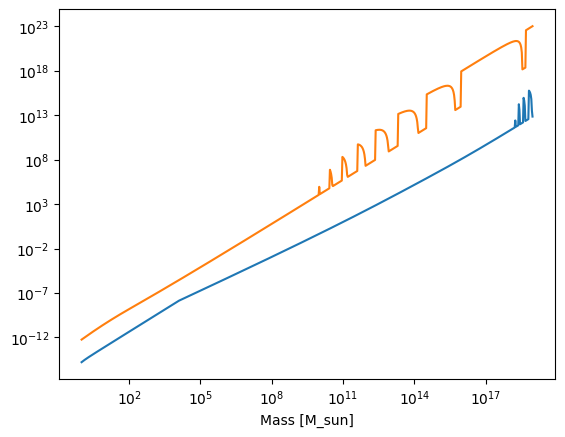

In [14]:
plt.plot(m_range, annihilation_rates[0])
plt.plot(m_range, annihilation_rates[-1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass [M_sun]')